In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect (reads database and builds SQLAlchemy Table objects) an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
#inspector = inspect(engine)
#columns = inspector.get_columns('measurement')
#for column in columns:
 #   print(column["name"], column["type"])


In [8]:
#columns = inspector.get_columns('station')
#for column in columns:
 #   print(column["name"], column["type"])

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [10]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [11]:
engine.execute(('SELECT * FROM measurement LIMIT 2')).fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0)]

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

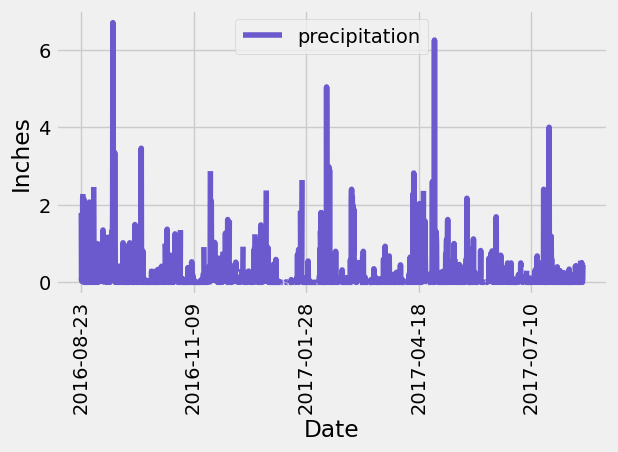

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago_date=dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
past_year_data= session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23').all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(past_year_data, columns=['date', 'prcp'])
df=df.rename(columns= {'date': 'Date', 'prcp':'precipitation'})

# Sort the dataframe by date
df.set_index('Date', inplace= True)
df=df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90, color = 'slateblue')
plt.ylabel("Inches")
plt.tight_layout()
plt.savefig("Analysis of Precipitation.png")
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
engine.execute(('SELECT * FROM station LIMIT 2')).fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)]

In [16]:
# Design a query to calculate the total number of stations in the dataset
stations_count = session.query(Station.id).count()
print(stations_count)

9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_station 


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

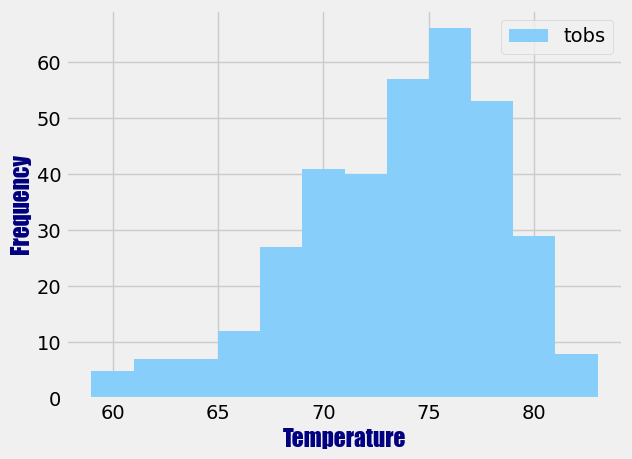

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
past_year_obs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date  <= '2017-08-23').\
    filter (Measurement.station == most_active_station[0][0]).all()
            
df = pd.DataFrame(past_year_obs)
#plot
df.plot.hist(bins=12, color = 'lightskyblue' )
plt.xlabel('Temperature', family= 'fantasy', color= "navy")
plt.ylabel('Frequency',family= 'fantasy', color= 'navy')
plt.tight_layout()
plt.savefig("Temperature Observation.png")
plt.show()



# Close Session

In [20]:
# Close Session
session.close()